In [1]:
import numpy as np
import tensorflow as tf
import transformers
import tf_keras


print("Python OK")
print("TensorFlow:", tf.__version__)
print("Transformers:", transformers.__version__)
print("tf-keras:", tf_keras.__version__)

e:\MindEmotion\Backend\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python OK
TensorFlow: 2.15.0
Transformers: 4.36.2
tf-keras: 2.15.0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
dataset = load_dataset("dair-ai/emotion")
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
emotion_labels = dataset["train"].features["label"].names
emotion_labels


['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

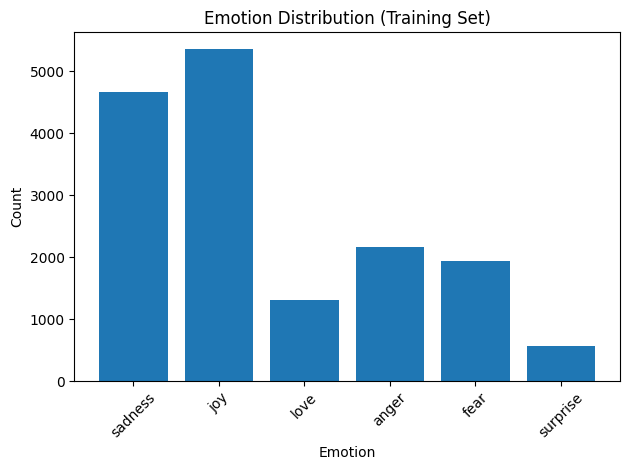

In [5]:
labels = dataset["train"]["label"]
counts = np.bincount(labels, minlength=len(emotion_labels))

plt.figure()
plt.bar(range(len(emotion_labels)), counts)
plt.xticks(range(len(emotion_labels)), emotion_labels, rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Distribution (Training Set)")
plt.tight_layout()
plt.show()


In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


e:\MindEmotion\Backend\venv\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
MAX_LEN = 128

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",   # FORCE fixed length
        max_length=MAX_LEN
    )

train_data = dataset["train"].map(tokenize, batched=True, remove_columns=["text"])
test_data  = dataset["test"].map(tokenize, batched=True, remove_columns=["text"])


Map: 100%|██████████| 2000/2000 [00:00<00:00, 4324.87 examples/s]


In [8]:
BATCH_SIZE = 16

train_tf = train_data.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

test_tf = test_data.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=BATCH_SIZE,
)


e:\MindEmotion\Backend\venv\lib\site-packages\datasets\arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [9]:
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(emotion_labels)
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [11]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
history = model.fit(train_tf, epochs=2)


Epoch 1/2


1000/1000 [==============================] - 4548s 5s/step - loss: 0.4887 - accuracy: 0.8329
Epoch 2/2
1000/1000 [==============================] - 4414s 4s/step - loss: 0.1422 - accuracy: 0.9404


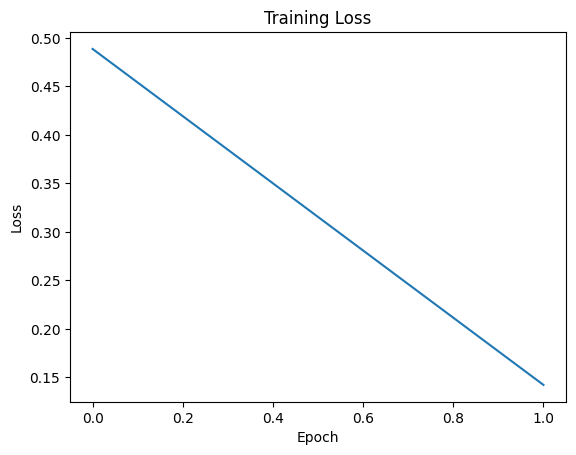

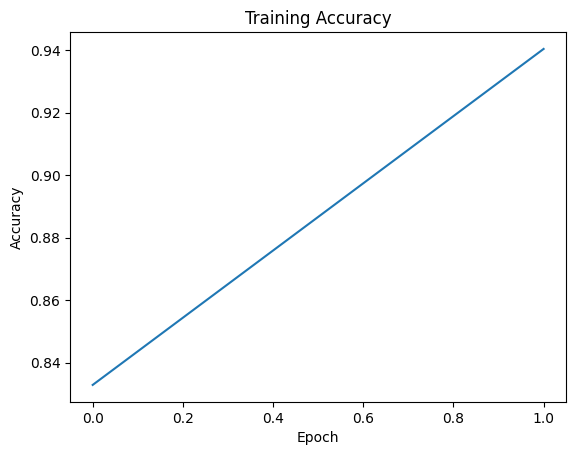

In [13]:
plt.figure()
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()


In [14]:
pred = model.predict(test_tf)
y_pred = np.argmax(pred.logits, axis=1)
y_true = np.concatenate([y for x, y in test_tf], axis=0)

print(classification_report(y_true, y_pred, target_names=emotion_labels))


125/125 [==============================] - 221s 1s/step
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.98      0.91      0.94       695
        love       0.75      0.93      0.83       159
       anger       0.90      0.93      0.92       275
        fear       0.95      0.83      0.89       224
    surprise       0.67      0.95      0.79        66

    accuracy                           0.93      2000
   macro avg       0.87      0.92      0.89      2000
weighted avg       0.93      0.93      0.93      2000



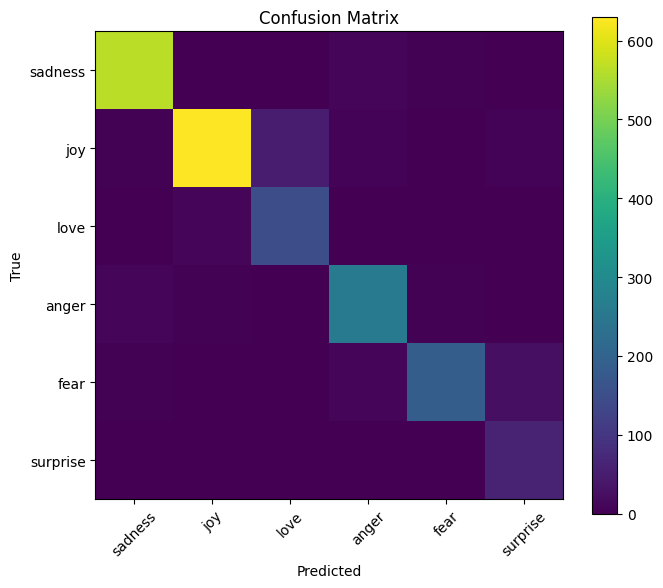

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm)
plt.colorbar()
plt.xticks(range(len(emotion_labels)), emotion_labels, rotation=45)
plt.yticks(range(len(emotion_labels)), emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [16]:
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(inputs)
    pred_id = tf.argmax(outputs.logits, axis=1).numpy()[0]
    return emotion_labels[pred_id]

predict_emotion("I feel lonely and tired these days")


'sadness'

In [18]:
model.save_pretrained("mindemotion_task1_model")
tokenizer.save_pretrained("mindemotion_task1_model")



('mindemotion_task1_model\\tokenizer_config.json',
 'mindemotion_task1_model\\special_tokens_map.json',
 'mindemotion_task1_model\\vocab.txt',
 'mindemotion_task1_model\\added_tokens.json',
 'mindemotion_task1_model\\tokenizer.json')